## MNIST Adversarial defense using SymDNN - This notebook has limited number of  vizualizations

In [1]:
# Basic imports & definitions for MNIST inference
import torch
import random
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import faiss
import sys
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100 
sys.path.insert(1, '../core')
from patchutils import symdnn_purify, fm_to_symbolic_fm as sym_mnist

In [2]:
# Basic model for MNIST inference

#  From my training code

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(),
                                      transforms.Normalize((0.1309,), (0.2893,))])
# Change the dataset folder to the proper location in a new system
testset = datasets.MNIST(root='../../../dataset', train=False, download=True, transform=apply_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
testloader_std = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

random_indices = list(range(0, len(testset), 5))
testset_subset = torch.utils.data.Subset(testset, random_indices)
testloader_subset = torch.utils.data.DataLoader(testset_subset, batch_size=1, shuffle=False)

class CNN_LeNet(nn.Module):
    def __init__(self):
        super(CNN_LeNet, self).__init__()
        # Define the net structure
        # This is the input layer first Convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10) 
    
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x,dim=1)
        return x

In [3]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### The standard model "pretrained_model" is trained on normalized MNIST data
### The  model "pretrained_nr_model" is trained on data clamped between 0 & 1
### The  model "pretrained_sc_model" is trained on data scaled between 0 & 1

In [4]:
pretrained_sc_model = "./mnist_sc_v0_best.pt"
mnist_sc_model = CNN_LeNet()
mnist_sc_model.load_state_dict(torch.load("mnist_sc_v0_best.pt"))
mnist_sc_model.eval()

CNN_LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
# Define a custom function that will clamp the images between 0 & 1 , without being too harsh as torch.clamp 
def softclamp01(image_tensor):
    image_tensor_shape = image_tensor.shape
    image_tensor = image_tensor.view(image_tensor.size(0), -1)
    image_tensor -= image_tensor.min(1, keepdim=True)[0]
    image_tensor /= image_tensor.max(1, keepdim=True)[0]
    image_tensor = image_tensor.view(image_tensor_shape)
    return image_tensor

In [6]:
# Lets check the kind of prediction the model is doing - the standard non symbolic infrence
def mnist_test_base_acc(model, nr=0):
    base_clampled_clean = 0
    total = 0
    # Clean base  inference   
    for images, labels in testloader_std:
        with torch.no_grad():
            if nr == 0:
                X = images
            elif nr == 1:
                X = softclamp01(images)
            else:
                X = torch.clamp(images, 0,1)
            y = labels
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    base_clampled_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(base_clampled_clean / total) 

In [7]:
# Test accuracy of symbolic inference
def mnist_test_sym_acc(model, nr, sym_mnist,n_clusters, index,  patch_size, stride, channel_count, instr=False):
    correct = 0 
    total = 0 
    centroid_lut = index.reconstruct_n(0, n_clusters)
    if instr:
        pdf = np.zeros((n_clusters,), dtype=int)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            X, y = data
            if nr == 0:
                X = X
            elif nr == 1:
                X = softclamp01(X)
            else:
                X = torch.clamp(X, 0,1)
            if instr:
                Xsym_, pdf = sym_mnist(X.squeeze(), n_clusters, index, centroid_lut,  patch_size, stride, channel_count, ana=False, multi=False, instr=True, randomize=False, rlevel=None, rbalance=True, pdf=pdf)
            else:
                Xsym_ = sym_mnist(X.squeeze(), n_clusters, index, centroid_lut, patch_size, stride, channel_count, ana=False, multi=False, instr=False, randomize=False, rlevel=None, rbalance=True, pdf=None)
            Xsym = torch.from_numpy(Xsym_)
            Xsym = Xsym.unsqueeze(0)
            output = model.forward(Xsym.float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                total += 1
    if instr:
        return round(correct/total, 4), pdf
    else:
        return round(correct/total, 4)

### Lets now try the final combination, which is both model &  index trained with same scaled data  - we also try different symbol sizes to come up with the best clean accuracy

In [8]:
index_32 = faiss.read_index("./kmeans_img_mnist_k2_s0_c32_sc_v0.index")
n_clusters_32 = 32
patch_size = (2, 2)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters_32, index_32,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 32):{}% ".format(100*acc))

Symbolic test accuracy (codebook 32):99.11% 


In [ ]:
index = faiss.read_index("./kmeans_img_mnist_k4_s0_c32_sc_v0.index")
n_clusters=32
patch_size = (4, 4)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 32):{}% ".format(100*acc))

In [ ]:
index = faiss.read_index("./kmeans_img_mnist_k8_s0_c32_sc_v0.index")
n_clusters=32
patch_size = (8, 8)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 32):{}% ".format(100*acc))

In [ ]:
index_64 = faiss.read_index("./kmeans_img_mnist_k2_s0_c64_sc_v0.index")
n_clusters_64=64
patch_size = (2, 2)
channel_count = 1
repeat = 2
location=False
stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters_64, index_64,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 64):{}% ".format(100*acc))

In [ ]:
index = faiss.read_index("./kmeans_img_mnist_k4_s0_c64_sc_v0.index")
n_clusters=64
patch_size = (4, 4)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 64):{}% ".format(100*acc))

In [ ]:
index = faiss.read_index("./kmeans_img_mnist_k8_s0_c64_sc_v0.index")
n_clusters=64
patch_size = (8, 8)
channel_count = 1
repeat = 2
location=False
stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 64):{}% ".format(100*acc))

In [ ]:
index = faiss.read_index("./kmeans_img_mnist_k2_s0_c128_sc_v0.index")
n_clusters=128
patch_size = (2, 2)
channel_count = 1
repeat = 2
location=False
stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 128):{}% ".format(100*acc))

In [ ]:
index = faiss.read_index("./kmeans_k4_s0_c128_sc_mnist.index")
n_clusters=128
patch_size = (4, 4)
channel_count = 1
repeat = 2
location=False
stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 128):{}% ".format(100*acc))

In [10]:
index = faiss.read_index("./kmeans_k8_s0_c128_sc_mnist.index")
n_clusters=128
patch_size = (8, 8)
channel_count = 1
repeat = 2
location=False
stride = 0
centroid_lut = index.reconstruct_n(0, n_clusters)
acc = mnist_test_sym_acc(mnist_sc_model, 1, sym_mnist, n_clusters, index,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 128):{}% ".format(100*acc))

Symbolic test accuracy (codebook 128):95.69% 


In [11]:
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

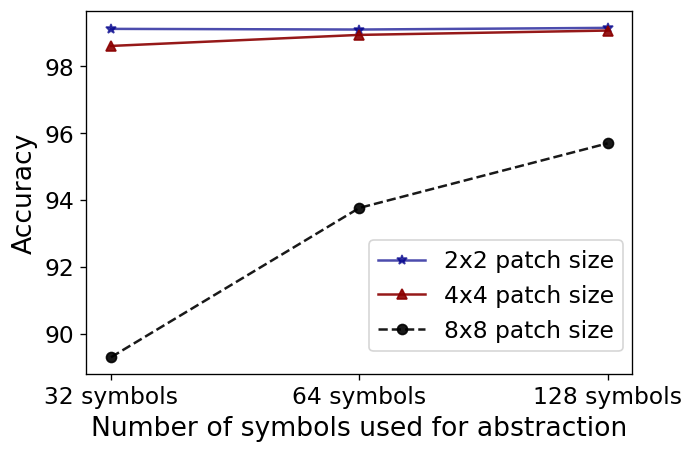

In [12]:
# Small hack in Jupyter
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 14})
N = 3
ind = np.arange(N)
labels = ('32 symbols', '64 symbols', '128 symbols')

k_2 = (99.11, 99.09, 99.14)
k_4 = (98.6, 98.93, 99.06)
k_8 = (89.3, 93.76, 95.69)
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.plot(ind, k_2, marker="*", alpha=0.7, color='darkblue')
rects2 = ax.plot(ind, k_4, marker="^", color='darkred',  alpha=0.9)
rects3 = ax.plot(ind, k_8, marker="o", linestyle="--", color='black',  alpha=0.9)

# add some
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Number of symbols used for abstraction', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(labels,  fontsize=14)
ax.legend( (rects1[0], rects2[0], rects3[0]), ('2x2 patch size', '4x4 patch size', '8x8 patch size'),loc='upper center', bbox_to_anchor=(0.75, 0.4))
plt.tight_layout()    
plt.show()
#plt.savefig('../patch_size_accuracy_mnist.png', format='png', dpi=1000)

In [ ]:
index_128 = faiss.read_index("./kmeans_img_mnist_k2_s0_c128_sc_v0.index")
n_clusters_128=128
patch_size = (2, 2)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_sc_model, 0, sym_mnist, n_clusters_128, index_128,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 128):{}% ".format(100*acc))

In [ ]:
index_256 = faiss.read_index("./kmeans_img_mnist_k2_s0_c256_sc_v0.index")
n_clusters_256=256
patch_size = (2, 2)
channel_count = 1
repeat = 2
location=False
stride = 0
acc = mnist_test_sym_acc(mnist_sc_model, 0, sym_mnist, n_clusters_256, index_256,  patch_size, stride, channel_count)
print("Symbolic test accuracy (codebook 256):{}% ".format(100*acc))

In [13]:
import torchvision.utils
from torchvision import models
import torchattacks
from torchattacks import *

print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.9.0+cu102
Torchvision 0.10.0+cu102
Torchattacks 3.2.0
Numpy 1.19.5


In [14]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
        
        
        
        
unorm = UnNormalize(mean=(0.1309), std=(0.2893))

In [15]:
 def plot_all(img, ttl, norm=False):
    # create figure (fig), and array of axes (ax)
    fig = plt.figure(figsize=(5, 2))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        j = i-1
        if norm:
            norm_img = unorm(img[j])
        else:
            norm_img = img[j]
        #npimg = norm_img.numpy()
        npimg = norm_img
        fig.add_subplot(rows, columns, i)
        plt.imshow(npimg,  cmap="gray")
        # write title for identification
        plt.rcParams.update({'font.size': 8})
        plt.rcParams["font.weight"] = "bold"
        plt.title(ttl[j])
        #axi.set_axis_off()
        plt.axis('off')

    plt.tight_layout(True)
    plt.show()

In [16]:
def viz_adversarial_attack(atk, model, index, n_clusters , num_try, sc,  norm=False):
    counter = 0
    correct_std = 0
    correct_std_atk = 0
    correct_sym = 0
    correct_sym_atk = 0
    total =0
    plot_count = 500
    patch_size = (2, 2)
    centroid_lut = index.reconstruct_n(0, n_clusters)
    for images, labels in testloader_subset:
        if sc: 
            # Soft clamp image to make the attack effective
            images_sc = softclamp01(images)
        else:
            images_sc = images
        if counter > num_try:
            break
        #print("For image #",counter)    
        counter += 1
        img_arr = []
        ttl_arr = []
        outputs_orig = model(images_sc)
        _, pre_orig = torch.max(outputs_orig.data, 1)
        if (pre_orig == labels): # We do further testing if the original model is right
            images_std = images_sc
            title_text = "Orig: "+str(classes[labels])
            if counter % plot_count == 0:
                plot_img = images_std.squeeze()
                plot_img = images.squeeze()
                img_arr.append(plot_img)
                ttl_arr.append(title_text)
            correct_std += (pre_orig == labels).sum()

            
            
            # Symbolic inference
            Xsym_ = sym_mnist(images_sc.squeeze(), n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            Xsym = torch.from_numpy(Xsym_)
            Xsym = Xsym.unsqueeze(0)
            outputs_sym = model.forward(Xsym.float())
            _, pre_sym = torch.max(outputs_sym.data, 1)
            if (pre_sym == labels):
                correct_sym += (pre_sym == labels).sum()
            if counter % plot_count == 0:    
                plot_img = Xsym.float().squeeze()
                img_arr.append(plot_img)
                title_text = "Sym: "+str(classes[pre_sym])
                ttl_arr.append(title_text)

            
            # Attack on vanila inference 
            adv_images = atk(images_sc, labels)
            outputs_std = model(adv_images)
            _, pre_std = torch.max(outputs_std.data, 1)
            if (pre_std == labels):
                correct_std_atk += (pre_std == labels).sum()
            if counter % plot_count == 0:
                plot_img_adv = adv_images.squeeze()
                plot_img = plot_img_adv.data.cpu().numpy().copy()
                img_arr.append(plot_img)
                title_text = "Orig (perturb) :"+str(classes[pre_std])
                ttl_arr.append(title_text)
                
            # Attack on symbolic inference 
            pfm = adv_images.data.cpu().numpy().copy()
            # Re-classify the perturbed image
            Xsym_ = sym_mnist(pfm.squeeze(), n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            Xsym = torch.from_numpy(Xsym_)
            Xsym = Xsym.unsqueeze(0)
            outputs_sym_atk = model.forward(Xsym.float())
            _, pre_sym_atk = torch.max(outputs_sym_atk.data, 1)
            if (pre_sym_atk == labels):
                correct_sym_atk += (pre_sym_atk == labels).sum()
            if counter % plot_count == 0:
                plot_img = Xsym.float().squeeze()
                img_arr.append(plot_img)
                title_text = "Sym (perturb):"+str(classes[pre_sym_atk])
                ttl_arr.append(title_text)
            
            if counter % plot_count == 0:
                plot_all(img_arr, ttl_arr, norm) 
        total += 1
            
    print('Attack on model: {}'.format(atk))
    print('Standard accuracy: %.2f %%' % (100 * float(correct_std) / total))
    print('Symbolic accuracy: %.2f %%' % (100 * float(correct_sym) / total))
    print('Attacked standard accuracy: %.2f %%' % (100 * float(correct_std_atk) / total))
    print('Attacked Symbolic accuracy: %.2f %%' % (100 * float(correct_sym_atk) / total))    

In [17]:
atks = [
    FGSM(mnist_sc_model, eps=8/255),
    BIM(mnist_sc_model, eps=8/255, alpha=2/255, steps=100),
    RFGSM(mnist_sc_model, eps=8/255, alpha=2/255, steps=100),
    CW(mnist_sc_model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(mnist_sc_model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(mnist_sc_model, eps=1, alpha=0.2, steps=100),
    EOTPGD(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(mnist_sc_model, eps=8/255, alpha=10/255),
    TPGD(mnist_sc_model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(mnist_sc_model),
    GN(mnist_sc_model, sigma=0.1),
    APGD(mnist_sc_model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(mnist_sc_model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(mnist_sc_model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(mnist_sc_model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(mnist_sc_model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(mnist_sc_model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(mnist_sc_model, eps=8/255, n_classes=10, version='standard'),
    OnePixel(mnist_sc_model, pixels=5, inf_batch=50),
    DeepFool(mnist_sc_model, steps=100),
    DIFGSM(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

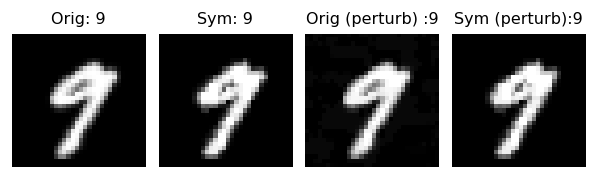

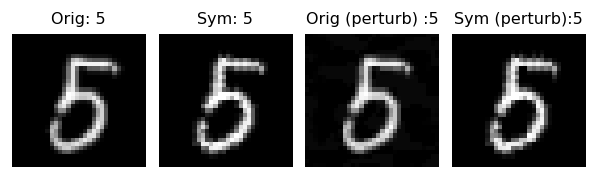

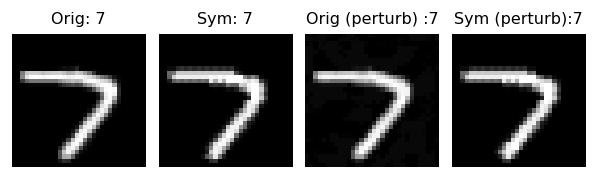

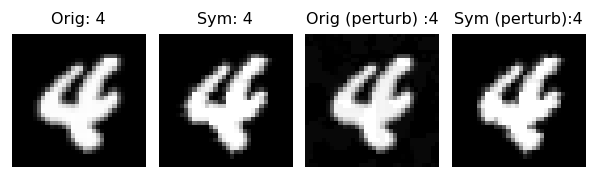

Attack on model: EOTPGD(model_name=CNN_LeNet, device=cpu, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, eot_iter=2, random_start=True, attack_mode=default, return_type=float)
Standard accuracy: 100.00 %
Symbolic accuracy: 100.00 %
Attacked standard accuracy: 100.00 %
Attacked Symbolic accuracy: 100.00 %


In [18]:
# Lets choose one attack. How about EOTPGD? doesnt take much time. Will also try longer ones - Autoattck.
attack_name_level = EOTPGD(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_32, n_clusters_32, 2000,  True,  norm=False)

In [ ]:
# Lets choose one attack. How about EOTPGD? doesnt take much time. Will also try longer ones - Autoattck.
attack_name_level = EOTPGD(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_64, n_clusters_64, 2000,  True,  norm=False)

In [ ]:
# Lets choose one attack. How about EOTPGD? doesnt take much time. Will also try longer ones - Autoattck.
attack_name_level = EOTPGD(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_128, n_clusters_128, 2000,  True,  norm=False)

In [ ]:
# Lets choose one attack. How about EOTPGD? doesnt take much time. Will also try longer ones - Autoattck.
attack_name_level = EOTPGD(mnist_sc_model, eps=8/255, alpha=2/255, steps=100, eot_iter=2)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_256, n_clusters_256, 2000,  True,  norm=False)

In [ ]:
# Lets choose one attack. How about EOTPGD? doesnt take much time. Will also try longer ones - Autoattck.
attack_name_level = EOTPGD(mnist_sc_model, eps=16/255, alpha=2/255, steps=100, eot_iter=2)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_32, n_clusters_32, 2000,  True,  norm=False)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_64, n_clusters_64, 2000,  True,  norm=False)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_128, n_clusters_128, 2000,  True,  norm=False)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_256, n_clusters_256, 2000,  True,  norm=False)

attack_name_level = EOTPGD(mnist_sc_model, eps=32/255, alpha=2/255, steps=100, eot_iter=2)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_32, n_clusters_32, 2000,  True,  norm=False)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_64, n_clusters_64, 2000,  True,  norm=False)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_128, n_clusters_128, 2000,  True,  norm=False)
viz_adversarial_attack(attack_name_level, mnist_sc_model, index_256, n_clusters_256, 2000,  True,  norm=False)

In [ ]:
# Small hack in Jupyter
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 14})
N = 3
ind = np.arange(N)
labels = ('8/255', '16/255', '32/255')

c_32 =    (98.4, 93.25, 73.85)
c_64 =    (98.05, 93.75, 69.10)
c_128 =    (97.55, 93.15, 68.50)
c_256 =    (97.85, 93.00, 63.35)
c_std =    (95.75, 85.80 ,29.60)

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.plot(ind, c_32, linestyle=":", alpha=0.7, color='darkblue')
rects2 = ax.plot(ind, c_64, linewidth="4", linestyle="-.", color='red',  alpha=0.9)
rects3 = ax.plot(ind, c_128, linestyle="-",  color='black')
rects4 = ax.plot(ind, c_256, linewidth="4", linestyle="--", color='lightcoral',  alpha=0.9)
rects5 = ax.plot(ind, c_std, color='yellow',  alpha=0.9)



# add some
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Attack strength: maximum change per pixel', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(labels,  fontsize=14)
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), ('Symbols:32', 'Symbols:64', 'Symbols:128', 'Symbols:256' , 'Non-symbolic'),loc='upper center', bbox_to_anchor=(0.3, 0.6))
plt.tight_layout()    
#plt.show()
plt.savefig('../strength_accuracy_symbols_mnist.png', format='png', dpi=1000)